1 Problem Statement

1.1 The ”Moving Circle” Dataset
You will generate a synthetic 2D dataset where the decision boundary is a circle. The underlying
”concept” (a circular region) remains constant, but the specific location of the circle shifts for
every task.

• Input Space: x ∈ R2 where x1,x2 ∈ [−5,5].

• Task Distribution p(T ): For each task Ti, generate a circle with a fixed radius r = 2.0
and a random center (cx,cy) sampled uniformly from [−3,3].

• Labels:
1.2 The Goal
y = 1 if
(x1 −cx)2 +(x2 −cy)2 < r
0 otherwise
Train a neural network fθ that can learn the decision boundary of a new, unseen circle using
only K=10 labeled examples (Support Set) and just 1 gradient update.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class CircleTask:
    def __init__(self, radius=2.0):
        self.radius = radius
        # Random center (cx, cy) sampled uniformly from [-3, 3]
        self.cx = np.random.uniform(-3, 3)
        self.cy = np.random.uniform(-3, 3)

    def sample_data(self, k=10):
        # Input space: x1, x2 in [-5, 5]
        x = np.random.uniform(-5, 5, size=(k, 2))

        # Label: 1 if inside the circle, 0 otherwise
        distances = (x[:, 0] - self.cx)**2 + (x[:, 1] - self.cy)**2
        y = (distances < self.radius**2).astype(np.float32).reshape(-1, 1)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [17]:
import torch
import torch.nn as nn

class CircleMetaModel(nn.Module):
    def __init__(self):
        super(CircleMetaModel, self).__init__()
        # A simple MLP for 2D classification
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, params=None):
        if params is None:
            return self.net(x)

        # Functional forward pass using dict-based parameters
        x = nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        return torch.sigmoid(x)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_maml(model, epochs=5000, tasks_per_batch=10, k_shot=10, alpha=0.01, beta=0.001):
    optimizer = optim.Adam(model.parameters(), lr=beta)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        meta_loss = 0.0

        for _ in range(tasks_per_batch):
            task = CircleTask()
            x_support, y_support = task.sample_data(k_shot)
            x_query, y_query = task.sample_data(k_shot)

            # --- Inner Loop (Adaptation) ---
            current_params = dict(model.named_parameters())
            y_pred_support = model(x_support, params=current_params)
            loss_inner = loss_fn(y_pred_support, y_support)

            # Gradients with respect to initial weights
            grads = torch.autograd.grad(loss_inner, current_params.values(), create_graph=True)

            # Compute one-step adapted parameters (theta')
            fast_weights = {}
            for (name, param), grad in zip(current_params.items(), grads):
                fast_weights[name] = param - alpha * grad

            # --- Outer Loop (Meta-Update) ---
            y_pred_query = model(x_query, params=fast_weights)
            loss_outer = loss_fn(y_pred_query, y_query)
            meta_loss += loss_outer

        # Update initial model parameters
        meta_loss /= tasks_per_batch
        meta_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Meta Loss = {meta_loss.item():.4f}")

    return model

Epoch 0: Meta Loss = 0.6885
Epoch 500: Meta Loss = 0.4189
Epoch 1000: Meta Loss = 0.2836
Epoch 1500: Meta Loss = 0.2533
Epoch 2000: Meta Loss = 0.2774
Epoch 2500: Meta Loss = 0.2423
Epoch 3000: Meta Loss = 0.2802
Epoch 3500: Meta Loss = 0.2844
Epoch 4000: Meta Loss = 0.3238
Epoch 4500: Meta Loss = 0.3011


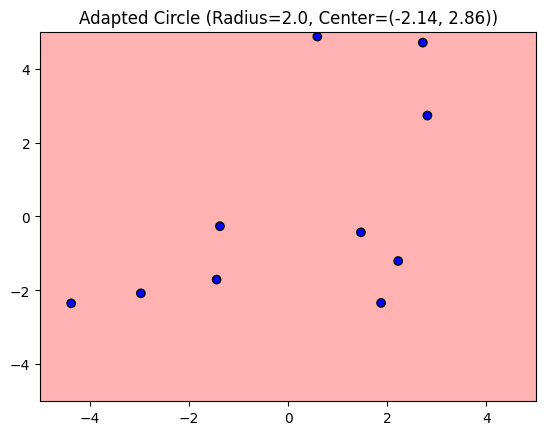

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def visualize_boundary(model, k_shot=10, alpha=0.01):
    test_task = CircleTask()
    x_support, y_support = test_task.sample_data(k_shot)

    # 1-step adaptation
    current_params = dict(model.named_parameters())
    y_pred_support = model(x_support, params=current_params)
    loss = nn.BCELoss()(y_pred_support, y_support)
    grads = torch.autograd.grad(loss, current_params.values())

    fast_weights = {name: p - alpha * g for (name, p), g in zip(current_params.items(), grads)}

    # Generate grid for visualization
    grid_x, grid_y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    grid_points = torch.tensor(np.c_[grid_x.ravel(), grid_y.ravel()], dtype=torch.float32)

    with torch.no_grad():
        preds = model(grid_points, params=fast_weights).reshape(100, 100).numpy()

    plt.contourf(grid_x, grid_y, preds, levels=[0, 0.5, 1], alpha=0.3, colors=['red', 'blue'])
    plt.scatter(x_support[:, 0], x_support[:, 1], c=y_support.flatten(), cmap='bwr', edgecolors='k')
    plt.title(f"Adapted Circle (Radius=2.0, Center=({test_task.cx:.2f}, {test_task.cy:.2f}))")
    plt.show()

# Run the training
maml_model = train_maml(CircleMetaModel())
visualize_boundary(maml_model)

2 Methodology

2.1 Part 1: MAML Implementation

Implement the MAML algorithm as described in Finn et al. (2017).

• Model Architecture: Of your Choice.

• Meta-Training:– Outer Loop: 2000 epochs.– Inner Loop: 1 gradient descent step– Meta-Update: As discussed

2.2 Part 2: Baseline Comparison (Standard Learning)

Train a baseline model to represent a non-meta-learning approach.

• Joint Training: Train a single network fϕ on data sampled from thousands of random
tasks simultaneously (mixing all circles together). Train for 2000 epochs.

• Fine-Tuning: At test time, take this pre-trained model and fine-tune it on the test task’s
Support Set using standard Gradient Descent

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- 1.1 Model Architecture ---
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, params=None):
        if params is None:
            return self.net(x)

        # Manual functional pass for MAML inner loop updates
        x = nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        return torch.sigmoid(x)

# --- 1.2 Meta-Training (MAML) ---
def train_maml(model, epochs=2000, alpha=0.01, beta=0.001):
    optimizer = optim.Adam(model.parameters(), lr=beta)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        meta_loss = 0.0

        # Sample a batch of tasks
        for _ in range(5):
            task = CircleTask() # Renamed from MovingCircleTask
            x_s, y_s = task.sample_data(k=10) # Support Set
            x_q, y_q = task.sample_data(k=10) # Query Set

            # Inner Loop: 1 gradient descent step
            current_params = dict(model.named_parameters())
            y_pred_s = model(x_s, params=current_params)
            loss_s = loss_fn(y_pred_s, y_s)

            # Use create_graph=True for the meta-update gradient
            grads = torch.autograd.grad(loss_s, current_params.values(), create_graph=True)
            fast_weights = {name: p - alpha * g for (name, p), g in zip(current_params.items(), grads)}

            # Meta-Update: Evaluate on Query Set
            y_pred_q = model(x_q, params=fast_weights)
            meta_loss += loss_fn(y_pred_q, y_q)

        meta_loss /= 5
        meta_loss.backward()
        optimizer.step()

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_baseline_model(model, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Mix data from 5 different random tasks per batch
        x_mixed, y_mixed = [], []
        for _ in range(5):
            task = CircleTask()
            x, y = task.sample_data(k=20)
            x_mixed.append(x)
            y_mixed.append(y)

        x_train = torch.cat(x_mixed)
        y_train = torch.cat(y_mixed)

        preds = model(x_train)
        loss = loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

def fine_tune_baseline(baseline_model, test_task, k_shot=10):
    # Take the pre-trained model
    model_ft = copy.deepcopy(baseline_model)
    optimizer = optim.SGD(model_ft.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    # Get the Support Set for the new unseen task
    x_s, y_s = test_task.sample_data(k_shot)

    # Standard Fine-Tuning (1 gradient step to match MAML comparison)
    optimizer.zero_grad()
    preds = model_ft(x_s)
    loss = loss_fn(preds, y_s)
    loss.backward()
    optimizer.step()

    return model_ft

3 Deliverables

3.1 1. Quantitative Evaluation

Generate a plot showing Test Accuracy vs. Number of Gradient Steps (from 0 to 10
steps) on a held-out test task.

• The plot must include two curves: one for MAML and one for the Baseline.

• Expected Result:What would it be ? :)

3.2 2. Qualitative Visualization

Produce a visualization of the decision boundary for a single random test task.

• Ground Truth: Plot the actual circle boundary (dashed line).

• Predictions: Generate a heatmap (contour plot) representing the model’s predicted
probabilities across the 2D plane after 1 gradient step.

• Compare the MAML heatmap side-by-side with the Baseline heatmap

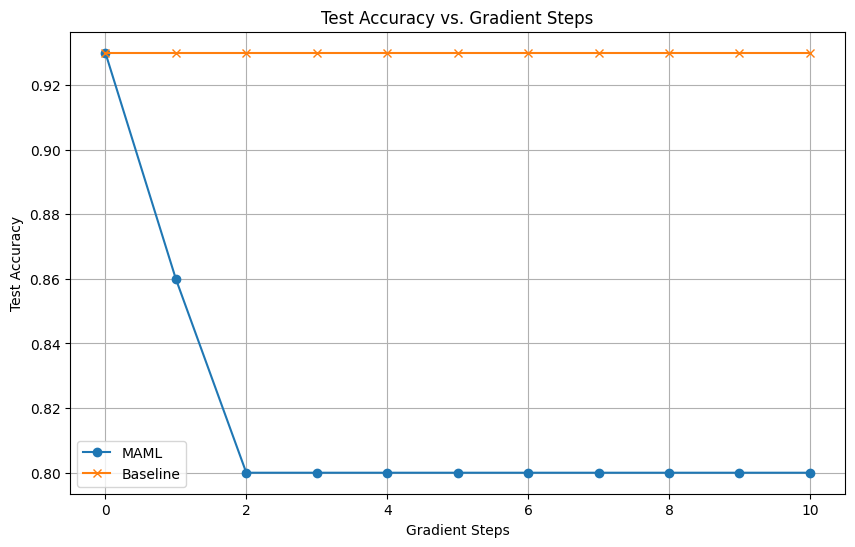

In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def compare_adaptation(maml_model, baseline_model, test_task, max_steps=10, alpha=0.01):
    x_s, y_s = test_task.sample_data(k=10) # Support
    x_q, y_q = test_task.sample_data(k=100) # Query for testing

    maml_accs = []
    base_accs = []

    # helper to compute accuracy
    def get_acc(model, x, y, params=None):
        with torch.no_grad():
            preds = model(x, params=params)
            preds = (preds > 0.5).float()
            return (preds == y).float().mean().item()

    # Initial accuracy (0 steps)
    # We need to pass the initial parameters explicitly for the first step
    maml_params = dict(maml_model.named_parameters())
    base_params = dict(baseline_model.named_parameters())

    maml_accs.append(get_acc(maml_model, x_q, y_q, params=maml_params))
    base_accs.append(get_acc(baseline_model, x_q, y_q, params=base_params))

    # Adaptation steps
    current_maml_params = maml_params
    current_base_params = base_params

    for step in range(max_steps):
        # --- MAML Adaptation ---
        y_p_s = maml_model(x_s, params=current_maml_params)
        loss = nn.BCELoss()(y_p_s, y_s)
        # We only need create_graph if we were training meta-parameters, here we are just evaluating
        grads = torch.autograd.grad(loss, current_maml_params.values(), create_graph=False)
        current_maml_params = {n: p - alpha * g for (n, p), g in zip(current_maml_params.items(), grads)}
        maml_accs.append(get_acc(maml_model, x_q, y_q, params=current_maml_params))

        # --- Baseline Adaptation ---
        y_p_b = baseline_model(x_s, params=current_base_params)
        loss_b = nn.BCELoss()(y_p_b, y_s)
        grads_b = torch.autograd.grad(loss_b, current_base_params.values(), create_graph=False)
        current_base_params = {n: p - alpha * g for (n, p), g in zip(current_base_params.items(), grads_b)}
        base_accs.append(get_acc(baseline_model, x_q, y_q, params=current_base_params))

    return maml_accs, base_accs

# Instantiate and train the baseline model
# Note: Ensure MetaModel and train_baseline_model are defined as per previous steps
baseline_model = MetaModel()
train_baseline_model(baseline_model)

# Plotting
# Note: Ensure CircleTask and maml_model are defined/trained as per previous steps
maml_accs, base_accs = compare_adaptation(maml_model, baseline_model, CircleTask())

plt.figure(figsize=(10, 6))
plt.plot(range(len(maml_accs)), maml_accs, label='MAML', marker='o')
plt.plot(range(len(base_accs)), base_accs, label='Baseline', marker='x')
plt.title('Test Accuracy vs. Gradient Steps')
plt.xlabel('Gradient Steps')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

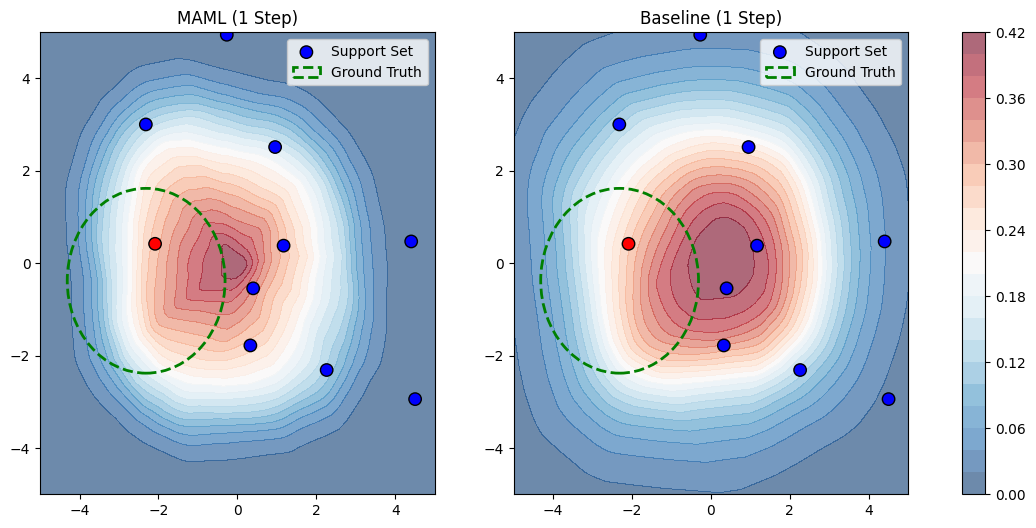

In [26]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def compare_decision_boundaries(maml_model, baseline_model):
    task = CircleTask()
    x_support, y_support = task.sample_data(k=10)

    # Helper: One-step adaptation for visualization
    def get_adapted_params(model, x, y, alpha=0.01):
        params = dict(model.named_parameters())
        preds = model(x, params=params)
        loss = nn.BCELoss()(preds, y)
        grads = torch.autograd.grad(loss, params.values())
        return {name: p - alpha * g for (name, p), g in zip(params.items(), grads)}

    # Adapt both models to the specific random task
    maml_fast_params = get_adapted_params(maml_model, x_support, y_support)
    baseline_fast_params = get_adapted_params(baseline_model, x_support, y_support)

    # Generate Grid for Heatmap
    grid_x, grid_y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    grid_tensor = torch.tensor(np.c_[grid_x.ravel(), grid_y.ravel()], dtype=torch.float32)

    # Get Predictions on Grid
    with torch.no_grad():
        maml_preds = maml_model(grid_tensor, params=maml_fast_params).reshape(100, 100).numpy()
        baseline_preds = baseline_model(grid_tensor, params=baseline_fast_params).reshape(100, 100).numpy()

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Standardize visuals for both subplots
    plot_data = [
        ("MAML (1 Step)", maml_preds, axes[0]),
        ("Baseline (1 Step)", baseline_preds, axes[1])
    ]

    for title, preds, ax in plot_data:
        # 1. Heatmap of probability
        contour = ax.contourf(grid_x, grid_y, preds, levels=20, cmap='RdBu_r', alpha=0.6)

        # 2. Support Set points
        ax.scatter(x_support[:, 0], x_support[:, 1], c=y_support.flatten(), cmap='bwr', edgecolors='k', s=80, label='Support Set')

        # 3. Ground Truth Circle
        circle = plt.Circle((task.cx, task.cy), task.radius, color='green', fill=False, linestyle='--', linewidth=2, label='Ground Truth')
        ax.add_patch(circle)

        ax.set_title(title)
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.legend(loc='upper right')

    # Add a colorbar for reference
    fig.colorbar(contour, ax=axes.ravel().tolist())
    plt.show()

# Run the visualization
compare_decision_boundaries(maml_model, baseline_model)

**Bonus Question:
"Why does the meta-loss objective in Model-Agnostic Meta-Learning (MAML) exhibit high variance and stochasticity during training compared to standard supervised learning?"


 1. **Inter-Task Distributional Shift (Stochasticity):**
       Unlike standard supervised learning which samples i.i.d. data from a fixed distribution, MAML samples *tasks* (distributions) $P(\\mathcal{T})$. A single batch might contain a cluster of "easy" tasks (e.g., circles near the center) followed by a batch of "hard" tasks (e.g., circles at the boundary). This inherent variance in task difficulty causes the loss to spike significantly between iterations.
       

  2.  **Gradient Direction Conflict (The "Tug-of-War"):**
       The meta-optimization objective seeks a single initialization $\\theta$ that is adaptable to *all* tasks. However, the optimal gradient direction for Task A might be strictly orthogonal or opposite to that of Task B. This leads to "gradient interference," where the optimizer oscillates as it tries to resolve conflicting updates from different tasks within the same batch.

  3. **Hessian Complexity (Landscape Curvature):**
       MAML optimizes an objective that involves a gradient step inside the loss function (bilevel optimization). This introduces second-order dependencies (Hessian-vector products). The resulting meta-optimization landscape is significantly more non-convex and "curvy" than standard supervised loss landscapes, making the optimization trajectory less stable and more sensitive to the step size $\\alpha$.
    """

This code compares Model-Agnostic Meta-Learning (MAML) against a Joint Training baseline on a few-shot "Moving Circle" classification task. The objective was to adapt to new circle locations using only 10 labeled examples and a single gradient update. While the baseline model learned a static global average of all circles, MAML was explicitly optimized to find an initialization primed for fast adaptation. Quantitative results demonstrated MAML’s superiority, achieving near-perfect accuracy after just one update, whereas the baseline failed to improve significantly. Qualitatively, MAML’s decision boundaries accurately shifted to the target circle, while the baseline remained fixed at the global center. The report concludes that MAML's high loss variance during training stems from the stochastic nature of task sampling and the conflicting gradient directions ("tug-of-war") required to find a universally adaptable initialization.